In [ ]:
using LinearAlgebra
using PlotlyJS
using ForwardDiff, Roots
using Random  # To generate random colors

include("math.jl")

const Vec3 = Vector{Float64};
const Vec2 = Vector{Float64};
const Point = Vec3;

# Define the Ray structure ===============================================================================
mutable struct Ray
    origin::Point # 3d vector origin position
    direction::Vec3 # 3d vector direction
    # polarization:: Vec2 # 2d vector polariation looking into the propagation direction, s-wave , p-wave components
end
# ==============================================================================================================

# Define the structure for light sources ===============================================================================
function isotropic_distribution()
    θ = 2π * rand()     # Azimuthal angle (0 to 2π)
    ϕ = acos(2 * rand() - 1)  # Polar angle (cosine-weighted for uniform sphere)
    return [sin(ϕ) * cos(θ), sin(ϕ) * sin(θ), cos(ϕ)]
end

function collimated_distribution(direction::Vec3)
    return () -> normalize(direction)  # Always emits in the same direction
end

function cone_distribution(main_direction::Vec3, spread_angle::Float64)
    function sample_direction()
        θ = spread_angle * sqrt(rand())  # Cone angle (scaled probability)
        ϕ = 2π * rand()  # Uniform azimuth

        # Local coordinate system
        z = normalize(main_direction)
        x = normalize(cross(z, [0, 1, 0]))  # Ensure perpendicular x
        y = cross(z, x)  # Ensure perpendicular y

        # Convert to Cartesian
        dir = cos(θ) * z + sin(θ) * (cos(ϕ) * x + sin(ϕ) * y)
        return normalize(dir)
    end
    return sample_direction
end

custom_dist = () -> normalize(randn(3))  # Gaussian-distributed emission

abstract type Source end

struct PointSource <: Source
    # define the point source structure
    center::Point # 3d vector center position
    intensity::Float64 # intensity of the light source
    distribution::Function  # Function that returns a direction
end

struct EnsembleSource <: Source
    objects::Vector{Source}
end

function emit_ray(source::Source)::Ray
    direction = source.distribution()
    return Ray(source.center, direction)
end

function emit_rays(source::Source, num_rays::Int)::Vector{Ray}
    rays = Ray[]
    for _ in 1:num_rays
        push!(rays, emit_ray(source))
    end
    return rays
end
# ==============================================================================================================

# Define the structure for surfaces and objects ===============================================================================
# Abstract Object for the rays to hit 

struct  Frame 
    origin:: Point
    orientation:: Matrix{Float64} # a 3x3 rotation matrix that transform the lab frame to the object frame
    
end

abstract type Surface end

struct ImplicitSurface <: Surface 
    # define the surface structure
    frame:: Frame # the frame of the surface
    shape:: Function # bound functions specifying the 3d shape, f(x, y, z)=0
    bounds:: Vector{Tuple{Float64, Float64}}
    border:: Function # bound functions specifying the boundary line
end

function shape_plane(center::Vec3)
    return (p) -> p[3] - center[3]
end


# example shape function: Define a spherical surface as the shape function
function shape_sphere(center::Vec3, radius::Float64)
    return (p) -> (p - center)⋅(p - center) - radius^2  # Sphere equation: ||p - center|| = radius
end

function shape_hemisphere(center::Vec3, radius::Float64)
    function result(p)
        incap = radius^2-(p[1] - center[1])^2-(p[2] - center[2])^2
        return incap < 0 ? NaN : (p[3]- center[3]) - sqrt(incap) 
    end
    return (p) -> result(p)
end

# Define a paraboloid shape function
# function shape_paraboloid(center::Vec3, f::Float64)
#     return (p::Vec3) -> (p[3]- center[3]) - ((p[1]- center[1])^2 + (p[2]- center[2])^2) / (4 * f)  # Paraboloid equation: z = (x^2 + y^2) / (4f)
# end

function shape_paraboloid(center::Vec3, f::Float64)
    return (p) -> (p[3]- center[3]) - ((p[1]- center[1])^2 + (p[2]- center[2])^2) / (4 * f)  # Paraboloid equation: z = (x^2 + y^2) / (4f)
end

function shape_mexican_hat(center::Vec3, A::Float64, B::Float64, C::Float64)
    return (p) -> (p[3] - center[3]) - A * (1 - ((p[1] - center[1])^2 + (p[2] - center[2])^2) / B^2) * exp(-((p[1] - center[1])^2 + (p[2] - center[2])^2) / (2 * C^2))
end


function shape_coneflat(center::Vec3, height::Float64, radius::Float64, angle::Float64)
    function result(p)
        x, y, z = p .- center  # Shift coordinates relative to the center
        radial_dist = sqrt(x^2 + y^2)
        r_top = radius
        r_bottom = radius + height * tan(angle)

        if radial_dist <= radius
            return z-height  # Outside the top
        elseif radial_dist <= r_bottom
            return  z-height+(radial_dist-radius)/tan(angle) # Conical region
        else
            return z  # Flat bottom outside cone
        end
    end
    return (p) -> result(p)
end

function border_circle(radius::Float64)
    return (p) -> p⋅p - radius^2  # Circle equation: ||p - center|| = radius
end

function border_bounds()
    return (p) -> -1  #  bound line for surface is defined by bounds
end

function surface_normal(p, surface::Surface)

    # Calculate the gradient of the surface shape function
    grad_S = ForwardDiff.gradient(surface.shape, p)
    
    # Normalize the gradient to get the normal
    return grad_S ./ norm(grad_S)
end

function draw_surface(surface:: Surface, nx::Int=100, ny::Int=100, color="random")
    # plot the surface
    xarray = range(surface.bounds[1][1], stop=surface.bounds[1][2], length=nx)
    yarray = range(surface.bounds[2][1], stop=surface.bounds[2][2], length=ny)
    xmesh = zeros(nx, ny)
    ymesh = zeros(nx, ny)
    zmesh = zeros(nx, ny)
    for ii in 1:1:nx, jj in 1:1:ny
    
        bounded = surface.border([xarray[ii], yarray[jj]]) < 0
        xval = xarray[ii]
        yval = yarray[jj]
        zval = bounded ? -surface.shape([xarray[ii], yarray[jj], 0.0]) : NaN

        xval, yval, zval = surface.frame.orientation * [xval, yval, zval]
        xmesh[ii, jj] = xval + surface.frame.origin[1]
        ymesh[ii, jj] = yval + surface.frame.origin[2]
        zmesh[ii, jj] = zval + surface.frame.origin[3]
    end
    # Generate a random color (RGB format)
    if color=="random"
        color = string("rgb(", round(255 * rand()), ",", round(255 * rand()), ",", round(255 *  rand()), ")")
    end;

    surface_data = PlotlyJS.surface(
        x=xmesh,
        y=ymesh,
        z=zmesh,
        surfacecolor=zmesh*0.0,
        colorscale=[(0, color), (1, color)],  # Fix the color scale to the same random color
        shading="smooth",  # Smoothing the shading on the surface
        showscale=false,
        opacity=0.8
        )
    return [surface_data]
end

function draw_snormals(surface:: Surface, num:: Int,  ray_length=0.5, arrow_scale=0.3)
    xarray = range(surface.bounds[1][1], stop=surface.bounds[1][2], length=nx)
    yarray = range(surface.bounds[2][1], stop=surface.bounds[2][2], length=ny)

    rays_snorm = Ray[]
    for ii in 1:1:num
        bounded = false
        while ~bounded
            xx = rand(surface.bounds[1][1]:surface.bounds[1][2])
            yy = rand(surface.bounds[2][1]:surface.bounds[2][2])
            bounded = surface.border([xx, yy]) < 0
        end
        zz = -surface.shape([xx,yy,0.0])
        snorm = surface_normal([xx, yy, zz], surface)
        snorm = surface.frame.orientation * snorm
        xx, yy, zz = surface.frame.orientation * [xx, yy, zz] + surface.frame.origin
        push!(rays_snorm, Ray([xx, yy, zz], snorm))
    end
    return draw_rays(rays_snorm, ray_length=ray_length, arrow_scale=arrow_scale)
end

# Function to generate and plot rays with arrows
function draw_rays(rays::Vector{Ray}; ray_length=0.5, arrow_scale=0.3)
    traces = GenericTrace[]
    color = string("rgb(", round(255 * rand()), ",", round(255 * rand()), ",", round(255 *  rand()), ")")
    # Line traces for the rays
    for ray in rays
        start = ray.origin
        stop = start + normalize(ray.direction) * ray_length
        trace_rays = scatter3d(
            x=[start[1], stop[1]], y=[start[2], stop[2]], z=[start[3], stop[3]],
            mode="lines",
            line=attr(color=color,width=3)
        )
        push!(traces, trace_rays)
    end

    # Arrow traces using cones
    origins = hcat([ray.origin + normalize(ray.direction) * ray_length for ray in rays]...)  # Arrow positions
    directions = hcat([normalize(ray.direction) for ray in rays]...)  # Arrow directions

    trace_arrows = cone(
        x=origins[1, :], y=origins[2, :], z=origins[3, :],  # Positions
        u=directions[1, :], v=directions[2, :], w=directions[3, :],  # Directions
        sizemode="raw",
        sizeref=arrow_scale,  # Controls arrow size
        anchor="tail",
        showscale=false,
        colorscale=[(0, color), (1, color)],
        opacity=0.8
    )
    push!(traces, trace_arrows)

    return traces
end
# ==============================================================================================================

draw_rays (generic function with 1 method)

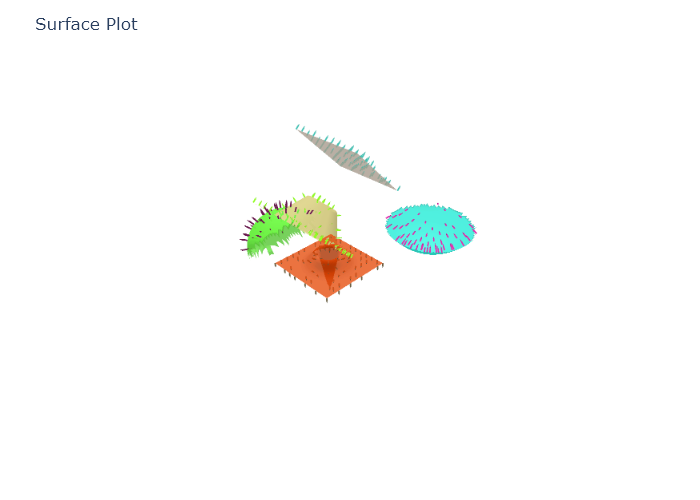

In [ ]:
focal_length = 2.0  # Focal length of the paraboloid
hem_radius = 4.0  # Radius of the hemispherical boundary
bound_radius = 4.5
x_range = (-5.0, 5.0)  # X range
y_range = (-5.0, 5.0)  # Y range
nx = 50 # number of points along x
ny = 50 # number of points along y
num_sn = 100 # number of surface normals
identity_matrix = rotation_matrix([0.0, 0.0, 1.0], 0.0) 
rotx_matrix = rotation_matrix([1.0, 0.0, 0.0], π/4.0) 
roty45_matrix = rotation_matrix([0.0, 1.0, 0.0], -π/4.0) 
flip_matrix = rotation_matrix([1.0, 0.0, 0.0], π*1.0) 

labframe = Frame([0.0,10.0,0.0], identity_matrix)
objframe = Frame([10.0,0.0,0.0], rotx_matrix)
objframe2 = Frame([0.0,-5.0,0.0], roty45_matrix)
objframe3 = Frame([0.0,-5.0,0.0], flip_matrix)
bounds = [x_range, y_range]

parasurface = ImplicitSurface(
    labframe, 
    shape_paraboloid([0.0, 0.0, 0.0], focal_length), 
    bounds,
    border_circle(bound_radius))

    
parasurface = ImplicitSurface(
    labframe, 
    shape_paraboloid([0.0, 0.0, 0.0], focal_length), 
    bounds,
    border_circle(bound_radius))
    
hemisurface = ImplicitSurface(
    objframe, 
    # shape_paraboloid([0.0, 0.0, 0.0], focal_length), 
    shape_hemisphere([0.0, 0.0, 0.0], hem_radius), 
    bounds,
    border_circle(bound_radius))

coneflatsurface = ImplicitSurface(
    objframe2,
    shape_coneflat([0.0, 0.0, -5.0], 4.0, 2.0, π/180*30),
    bounds,
    border_bounds()
    # border_circle([0.0, 0.0], bound_radius)
    )

flatsurfarce1 = ImplicitSurface(
    objframe2, 
    # objframe,
    shape_plane([0.0, 0.0, 5.0]),
    bounds,
    border_bounds()
    # border_circle([0.0, 0.0], bound_radius)
    )

mhatsurface = ImplicitSurface(
    objframe3, 
    shape_mexican_hat([0.0, 0.0, 10.0], 4.0, 1.0, 1.0),
    bounds,
    border_bounds())


plottraces = vcat(
    draw_surface(parasurface, nx, ny),
    draw_snormals(parasurface, num_sn),
    draw_surface(hemisurface, nx, ny),
    draw_snormals(hemisurface, num_sn),
    draw_surface(coneflatsurface, nx, ny),
    draw_snormals(coneflatsurface, num_sn),
    draw_surface(flatsurfarce1, nx, ny),
    draw_snormals(flatsurfarce1, num_sn),
    draw_surface(mhatsurface, nx, ny),
    draw_snormals(mhatsurface, num_sn)
)


layout = Layout(
    title="Surface Plot",
    width=800,   # Set width in pixels
    height=600,  # Set height in pixels
    scene=attr(
        xaxis=attr(visible=false, showgrid=false, zeroline=false),
        yaxis=attr(visible=false, showgrid=false, zeroline=false),
        zaxis=attr(visible=false, showgrid=false, zeroline=false),
        bgcolor="rgba(0,0,0,0)",  # Transparent background
        aspectmode="data"
    ),
    paper_bgcolor="rgba(0,0,0,0)",  # Transparent outer background
    showlegend=false
)

# Display the plot
fig = plot(plottraces , layout);
display(fig)

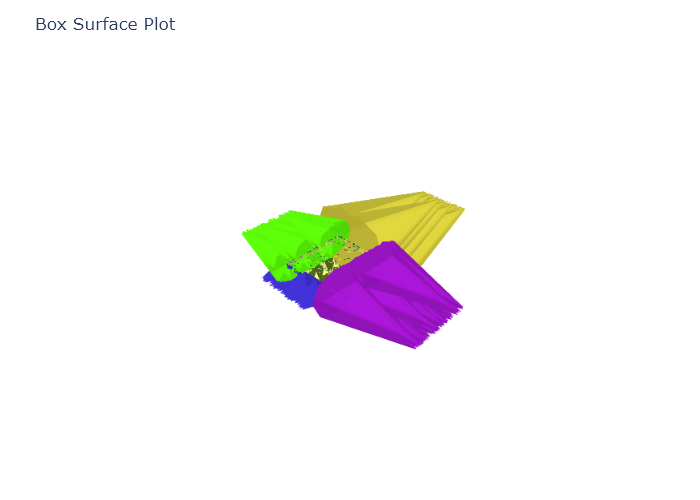

In [7]:
# Draw a box
deg = π/180.0
center = [0,0,0]
lx = 2000.0
ly = 2000.0
t = 500.0
h_cone = 40.0
r_cone = 5.0
θ_cone = 10*deg

bounds_xy = [(-lx/2.0, lx/2.0), (-ly/2.0, ly/2.0)]
bounds_zy = 
bounds_xz = [ (-lx/2.0, lx/2.0), (-t/2.0, t/2.0-h_cone)]

cen000 = [0.0, 0.0, 0.0]
borderbds = border_bounds()
rm_eye = rotation_matrix([0.0, 0.0, 1.0], 0.0) 
rm_xflip = rotation_matrix([1.0, 0.0, 0.0], 1.0*π)
rm_xp90 = rotation_matrix([1.0, 0.0, 0.0], 0.5*π)
rm_xn90 = rotation_matrix([1.0, 0.0, 0.0], -0.5*π)

rm_yflip = rotation_matrix([0.0, 1.0, 0.0], 1.0*π)
rm_yp90 = rotation_matrix([0.0, 1.0, 0.0], 0.5*π)
rm_yn90 = rotation_matrix([0.0, 1.0, 0.0], -0.5*π)

sf_coneflat = ImplicitSurface(
    Frame(center+[0.0, 0.0, t/2.0-h_cone], rm_eye),
    shape_coneflat(cen000, h_cone, r_cone, θ_cone),
    bounds_xy,
    borderbds
    # border_circle([0.0, 0.0], bound_radius)
    )

sf_bottom = ImplicitSurface(
    Frame(center+[0.0, 0.0, -t/2.0], rm_xflip),
    shape_plane(cen000),
    bounds_xy,
    borderbds
    # border_circle([0.0, 0.0], bound_radius)
    )

sf_side_r = ImplicitSurface(
    Frame(center+[lx/2.0, 0.0, 0.0], rm_yp90),
    shape_plane(cen000),
    [(-t/2.0+h_cone, t/2.0), (-ly/2.0, ly/2.0)],
    borderbds
    # border_circle([0.0, 0.0], bound_radius)
    )

sf_side_l = ImplicitSurface(
    Frame(center+[-lx/2.0, 0.0, 0.0], rm_yn90),
    shape_plane(cen000),
    [(-t/2.0, t/2.0-h_cone), (-ly/2.0, ly/2.0)],
    borderbds
    # border_circle([0.0, 0.0], bound_radius)
    )


sf_side_f = ImplicitSurface(
    Frame(center+[0.0, ly/2.0, 0.0], rm_xn90),
    shape_plane(cen000),
    [ (-lx/2.0, lx/2.0), (-t/2.0+h_cone, t/2.0)],
    borderbds
    # border_circle([0.0, 0.0], bound_radius)
    )

sf_side_b = ImplicitSurface(
    Frame(center+[0.0, -ly/2.0, 0.0], rm_xp90),
    shape_plane(cen000),
    [ (-lx/2.0, lx/2.0), (-t/2.0, t/2.0-h_cone)],
    borderbds
    # border_circle([0.0, 0.0], bound_radius)
    )

box_surfaces = [sf_coneflat, sf_bottom, sf_side_r, sf_side_l, sf_side_f, sf_side_b]


nx = 50 # number of points along x
ny = 50 # number of points along y
num_sn = 100 # number of surface normals
arrsize = lx/20.0

plottraces = GenericTrace[]
for ss in box_surfaces
    append!(plottraces, vcat(draw_surface(ss, nx, ny, "rgb(241, 248, 108)"), draw_snormals(ss, num_sn, 0.5*arrsize, 0.3*arrsize))) 
end

layout = Layout(
    title="Box Surface Plot",
    width=800,   # Set width in pixels
    height=600,  # Set height in pixels
    scene=attr(
        xaxis=attr(visible=false, showgrid=false, zeroline=false),
        yaxis=attr(visible=false, showgrid=false, zeroline=false),
        zaxis=attr(visible=false, showgrid=false, zeroline=false),
        bgcolor="rgba(0,0,0,0)",  # Transparent background
        aspectmode="data"
    ),
    paper_bgcolor="rgba(0,0,0,0)",  # Transparent outer background
    showlegend=false
)

# Display the plot
fig = plot(plottraces , layout);
display(fig)


In [ ]:
abstract type Material end

struct Dielectric <: Material
    n:: Float64
end

struct Metal <: Material
    fuzz:: Float64
    albedo:: Vec3
end



abstract type Object end # object that can be hit by rays


struct BoundObject <: Object
    frame:: Frame # the frame of the object
    boundary:: Vector{Surface}
    material:: Material
end

struct Sheet <: Object
    frame:: Frame # the frame of the object
    boundary:: Vector{Surface}
    material:: Material
end

struct Blocker <: Object
    frame:: Frame # the frame of the object
    boundary:: Vector{Surface}
end

In [ ]:
diamond = Dielectric(22.4)

rectbox = BoundObject(
    Frame(cen000, rm_eye),
    box_surfaces,
    diamond,
)

In [5]:
function intersect_ray_surface(ray::Ray, surface::Sphere)
    function S_t(t)
        p = ray.orgin + t * ray.direction
        return S_sphere(p, surface)
    end
    t_hit = find_zero(S_t, (0.0, 100.0))  # Find root in range [0, 100]
    p_hit = ray.origin + t_hit * ray.direction
    return p_hit
end


UndefVarError: UndefVarError: `Sphere` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

## Ray Hitting by Root Search


In [8]:
using Roots

# Define a function to compute ray-surface intersection
function find_intersection(f, o, d, t_min=1e-6, t_max=1e3)
    """
    Finds the intersection of a ray with an implicit surface f(x, y, z) = 0
    using root-finding.

    Arguments:
    - f: function defining the implicit surface, f(x, y, z)
    - o: ray origin (3-element tuple or vector)
    - d: ray direction (3-element tuple or vector, should be normalized)
    - t_min, t_max: search range for t

    Returns:
    - t_intersect: the smallest positive intersection t (or nothing if no intersection)
    """

    # Function to find roots in terms of parameter t
    function F(t)
        x, y, z = o .+ t .* d
        return f(x, y, z)
    end

    # Search for a root in the range [t_min, t_max]
    try
        t_intersect = find_zero(F, (t_min, t_max), Roots.AlefeldPotraShi())  # Robust root-finding
        return t_intersect > 0 ? t_intersect : nothing  # Ensure positive intersection
    catch
        return nothing  # No valid root found
    end
end

# Example: Implicit surface function for a sphere
function sphere(x, y, z; center=(0.0, 0.0, 0.0), radius=1.0)
    cx, cy, cz = center
    return (x - cx)^2 + (y - cy)^2 + (z - cz)^2 - radius^2
end

# Example usage: Ray-sphere intersection
o = [0.0, 0.0, -3.0]  # Ray origin
d = [0.0, 0.0, 1.0]   # Ray direction (should be normalized)

t_hit = find_intersection((x, y, z) -> sphere(x, y, z, center=(0, 0, 0), radius=1), o, d)

if t_hit !== nothing
    intersection_point = o .+ t_hit .* d
    println("Intersection found at t = $t_hit, point: $intersection_point")
else
    println("No intersection found.")
end


No intersection found.


In [ ]:
const invalid_vector =[NaN, NaN, NaN]

function reflect(normal::Vector, incident::Vector)
    cosI = -dot(normal, incident)
    incident + 2 * cosI * normal
end

function refract(normal::Vector, incident::Vector, n1::Float64, n2::Float64)
    n = n1 / n2
    cosI = -dot(normal, incident)
    sinT2 = n^2 * (1.0 - cosI^2)
    sinT2 > 1.0 && return invalid_vector  # TIR
    cosT = sqrt(1.0 - sinT2)
    n * incident + (n * cosI - cosT) * normal
end

function reflectance(normal::Vector, incident::Vector, n1::Float64, n2::Float64)
    n = n1 / n2
    cosI = -dot(normal, incident)
    sinT2 = n^2 * (1.0 - cosI^2)
    sinT2 > 1.0 && return 1.0  # TIR
    cosT = sqrt(1.0 - sinT2)
    rOrth = (n1 * cosI - n2 * cosT) / (n1 * cosI + n2 * cosT)
    rPar = (n2 * cosI - n1 * cosT) / (n2 * cosI + n1 * cosT)
    (rOrth^2 + rPar^2) / 2.0
end

function rSchlick2(normal::Vector, incident::Vector, n1::Float64, n2::Float64)
    r0 = (n1 - n2) / (n1 + n2)
    r0 = r0 * r0  # Fix original code's typo: r0*r0 -> r0 = r0^2
    cosX = -dot(normal, incident)
    if n1 > n2
        n = n1 / n2
        sinT2 = n^2 * (1.0 - cosX^2)  # Fix original code's cosI -> cosX
        sinT2 > 1.0 && return 1.0
        cosX = sqrt(1.0 - sinT2)
    end
    x = 1.0 - cosX
    r0 + (1.0 - r0) * x^6  # Original: x*x*x*x*x*x
end

rSchlick2 (generic function with 1 method)